# Load Dependencies and Check GPU Status

In [3]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np

# check if GPU is recognized
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Build Dataloading Function

In [4]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    # cast to 64 bit integer
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # make sure audio is 16k sampling rate
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav



### Plot Wave

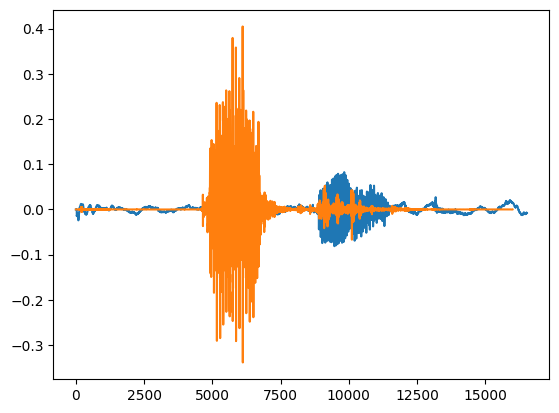

In [5]:
# raw data
BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/BadWords/fuck/tev (1).wav")
NOT_BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/NotBadWords/backward(1).wav")

wave = load_wav_16k_mono(BAD_FILE)
nwave = load_wav_16k_mono(NOT_BAD_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()

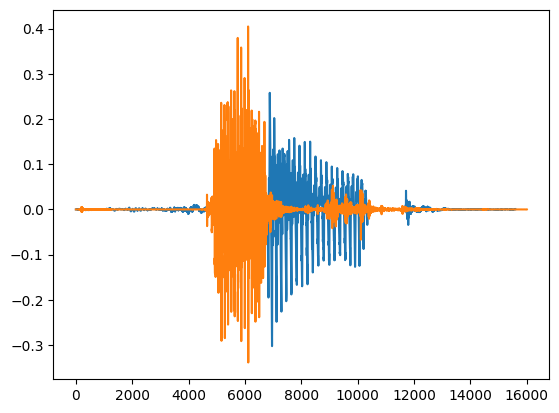

In [6]:
# normalized data
BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/BadWords/fuck_comp/tevin (1).wav")
NOT_BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/NotBadWords/NotBad_comp/backward(1).wav")

wave = load_wav_16k_mono(BAD_FILE)
nwave = load_wav_16k_mono(NOT_BAD_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()

# Create TensorFlow Dataset

In [7]:
# define paths to positive and negative data
NOT_BAD = os.path.join("C:/Users/jreye/ML_DATA/ML_dataset/notBad") 
FUCK = os.path.join("C:/Users/jreye/ML_DATA/ML_dataset/fuck") 
SHIT = os.path.join("C:/Users/jreye/ML_DATA/ML_dataset/shit") 

# Create multi-classification datasets
not_bad = tf.data.Dataset.list_files(NOT_BAD+'\*.wav').map(lambda x: (x, tf.constant([1, 0, 0], dtype=tf.float32))) 
fuck = tf.data.Dataset.list_files(FUCK+'\*.wav').map(lambda x: (x, tf.constant([0, 1, 0], dtype=tf.float32))) 
shit = tf.data.Dataset.list_files(SHIT+'\*.wav').map(lambda x: (x, tf.constant([0, 0, 1], dtype=tf.float32))) 

data = not_bad.concatenate(fuck)
data = data.concatenate(shit)

print("Size of not_bad dataset: " + repr(len(not_bad)))
print("Size of fuck dataset   : " + repr(len(fuck)))
print("Size of shit dataset   : " + repr(len(shit)))

# for debugging
#list(fuck.as_numpy_iterator())

Size of not_bad dataset: 1850
Size of fuck dataset   : 719
Size of shit dataset   : 618


## Determine Average Length of Sample

In [8]:
# calculate wave cycle length
lengths = []

# not bad files
for file in os.listdir(os.path.join(NOT_BAD)):
     tensor_wave = load_wav_16k_mono(os.path.join(NOT_BAD, file))
     lengths.append(len(tensor_wave))

# # # # fuck 
for file in os.listdir(os.path.join(FUCK)):
     tensor_wave = load_wav_16k_mono(os.path.join(FUCK, file))
     lengths.append(len(tensor_wave))
    
# # # # shit
for file in os.listdir(os.path.join(SHIT)):
     tensor_wave = load_wav_16k_mono(os.path.join(SHIT, file))
     lengths.append(len(tensor_wave))

In [9]:
# calculate mean
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=17078>

In [10]:
# calculate min
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=4458>

In [11]:
# calculate max
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=29907>

In [12]:
# ave length of bad word
tf.math.reduce_mean(lengths)/16000

<tf.Tensor: shape=(), dtype=float64, numpy=1.067375>

In [13]:
# min length of bad word
tf.math.reduce_min(lengths)/16000

<tf.Tensor: shape=(), dtype=float64, numpy=0.278625>

In [14]:
# max length of bad word
tf.math.reduce_max(lengths)/16000

<tf.Tensor: shape=(), dtype=float64, numpy=1.8691875>

# Build Preprocessing Function to Convert to Spectrogram

In [15]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:25000] # 25000 sample length (can make smaller to reduce processing time but will affect accuracy)
    zero_padding = tf.zeros([25000] - tf.shape(wav), dtype=tf.float32) 
    wav = tf.concat([zero_padding, wav],0) # pad clips longer than 25000 samples wiht zeros
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

[0. 0. 1.]


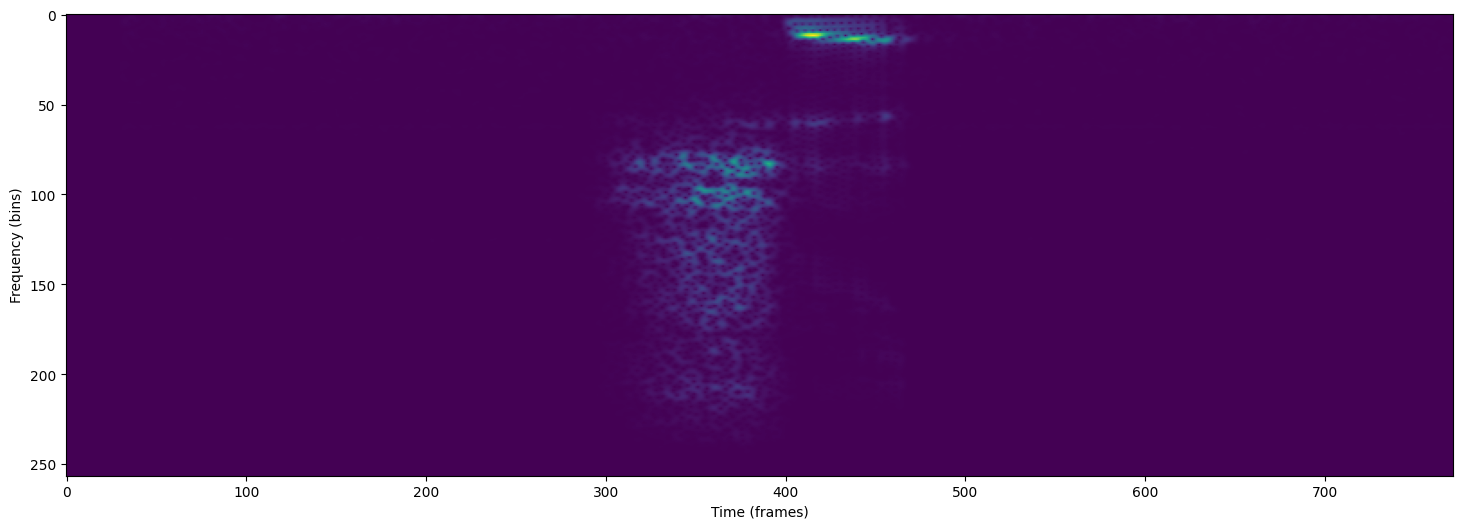

In [20]:
# test out the function and visualize the spectrogram (bad words)
# print from shit label
filepath, label = shit.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
print(label)
plt.figure(figsize=(18, 6))
plt.imshow(tf.transpose(spectrogram)[0])
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (bins)')
plt.show()

# Create Training and Testing Partitions

In [21]:
len(data)

3187

In [22]:
# create TensorFlow data pipeline
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=5000)
data = data.batch(16)
data = data.prefetch(16)

In [23]:
len(data)

200

In [24]:
len(data)*.7

140.0

In [25]:
len(data) - len(data)*.7

60.0

In [26]:
# split into training and testing partitions
train = data.take(140) # 70 % goes to train set
test = data.skip(140).take(60) # 30 % goes to test set

In [27]:
# test one batch
samples, labels = train.as_numpy_iterator().next()

In [28]:
samples.shape

(16, 772, 257, 1)

In [29]:
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

# Build Deep Learning Model

In [17]:
# load Keras Model dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Activation
from tensorflow.keras.callbacks import TensorBoard # to view statistics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, Recall, Precision
from tensorflow.keras.models import save_model, load_model

import time

# Training Various Configurations of Model

In [18]:
# test various configs of model
dense_layers = [0, 1] # 0 worked well so we check 0 and 1
layer_sizes = [16, 32, 64] # 32 worked well so we check 16 and 64
conv_layers = [2, 4] # 2 worked well so we check 2 and 4
dense_size = 128
epochs_num = 5

histories = []
models = []
model_names = []

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)
            

            # create layers
            model = Sequential() 
            model.add(Conv2D(layer_size, (3,3), input_shape= (772, 257, 1))) # depends on shape of spec
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3,3)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2,2)))

            model.add(Flatten())
            for l in range(dense_layer):                                                                                            
                model.add(Dense(dense_size))
                model.add(Activation("relu"))

            # output layer
            model.add(Dense(3))
            model.add(Activation("softmax"))  
   
            tensorboard = TensorBoard(log_dir='badWord_CNN_logs/{}'.format(NAME))

            model.compile(optimizer='Adam', # adam optimizer (can change to small learning rate)
                          loss='CategoricalCrossentropy', 
                          metrics=[Recall(), Precision(), CategoricalAccuracy()])

            #tensorboard analysis
            hist = model.fit(train, epochs=epochs_num, validation_data=test, callbacks = [tensorboard])
            
            # Append the history object and the model to the respective lists
            histories.append(hist)
            models.append(model)
            model_names.append(NAME)

2-conv-16-nodes-0-dense-1682585820
Epoch 1/5
140/140 [==============================] - 7s 33ms/step - loss: 0.6125 - recall: 0.6857 - precision: 0.8000 - categorical_accuracy: 0.7603 - val_loss: 0.4213 - val_recall: 0.7804 - val_precision: 0.8861 - val_categorical_accuracy: 0.8321
Epoch 2/5
140/140 [==============================] - 4s 31ms/step - loss: 0.3670 - recall: 0.8335 - precision: 0.8761 - categorical_accuracy: 0.8621 - val_loss: 0.2175 - val_recall: 0.9124 - val_precision: 0.9579 - val_categorical_accuracy: 0.9525
Epoch 3/5
140/140 [==============================] - 5s 35ms/step - loss: 0.2238 - recall: 0.9112 - precision: 0.9307 - categorical_accuracy: 0.9223 - val_loss: 0.1518 - val_recall: 0.9493 - val_precision: 0.9667 - val_categorical_accuracy: 0.9641
Epoch 4/5
140/140 [==============================] - 5s 38ms/step - loss: 0.1315 - recall: 0.9567 - precision: 0.9679 - categorical_accuracy: 0.9643 - val_loss: 0.0948 - val_recall: 0.9757 - val_precision: 0.9819 - val_ca

# Compare Different Model Structure Metrics

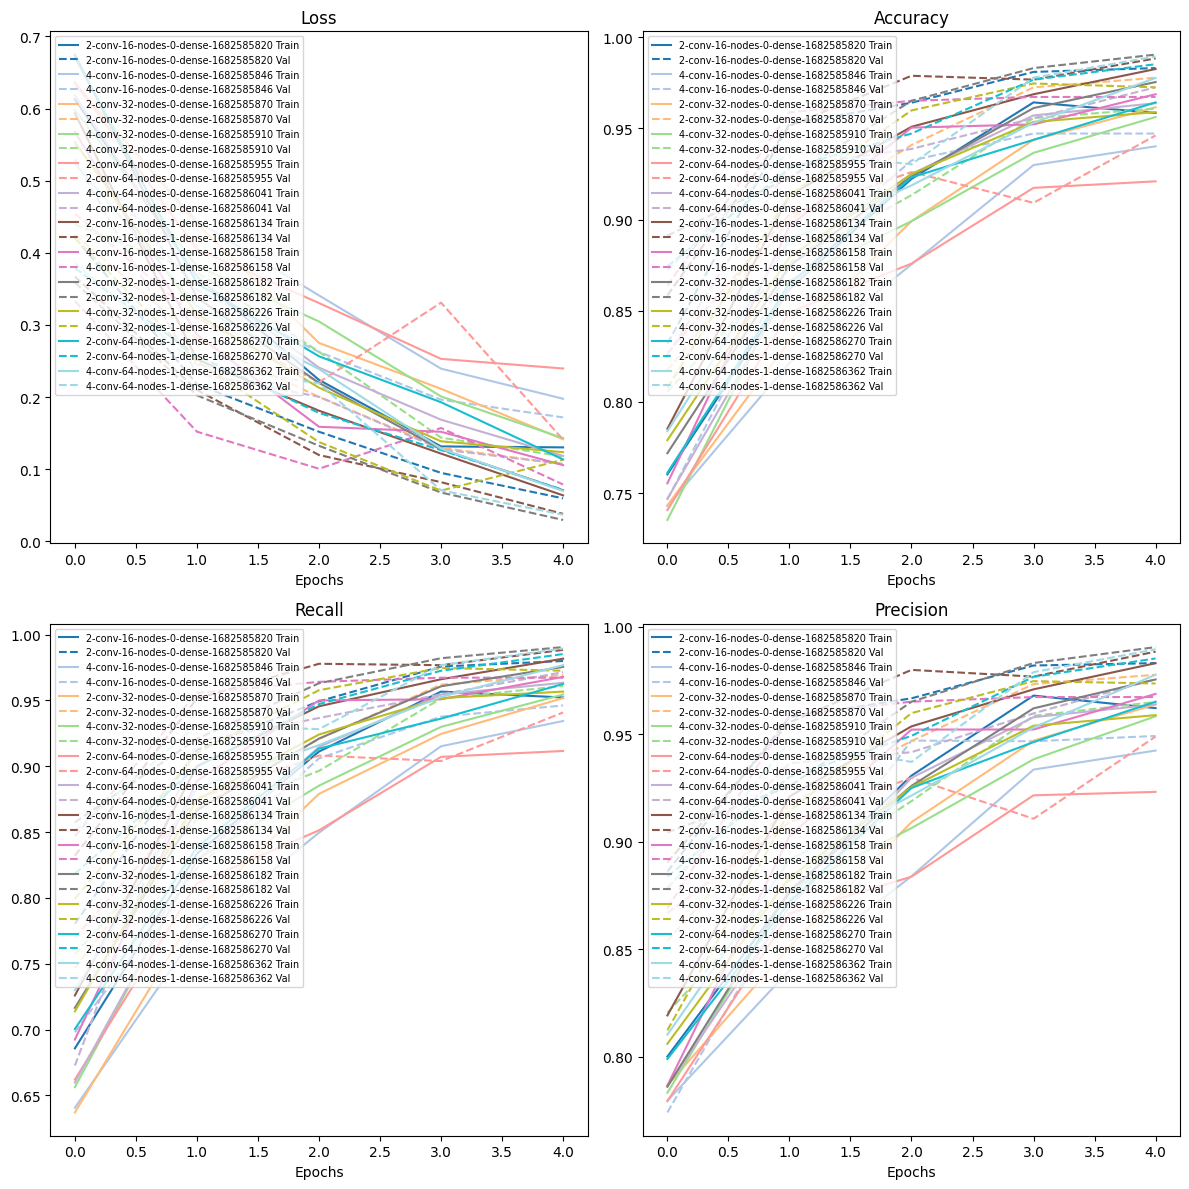

In [19]:
# Get the number of models
num_models = len(histories)

# Generate a colormap with increased contrast for the different models
colors = plt.cm.tab20(np.linspace(0, 1, num_models))

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

metrics = ['loss', 'categorical_accuracy', 'recall', 'precision']
titles = ['Loss', 'Accuracy', 'Recall', 'Precision']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    for j, hist in enumerate(histories):
        # Find the corresponding metric names in history
        train_metric = next(key for key in hist.history.keys() if metric in key and "val" not in key)
        val_metric = next(key for key in hist.history.keys() if metric in key and "val" in key)
        
        # Plot training metric
        axes[i].plot(hist.history[train_metric], color=colors[j], linestyle='-')
        # Plot validation metric
        axes[i].plot(hist.history[val_metric], color=colors[j], linestyle='--')
    
    axes[i].set_title(title)
    axes[i].set_xlabel('Epochs')
    
    # Create a custom legend
    legend_elements = []
    for k in range(num_models):
        legend_elements.append(plt.Line2D([0], [0], color=colors[k], linestyle='-', label=f'{model_names[k]} Train'))
        legend_elements.append(plt.Line2D([0], [0], color=colors[k], linestyle='--', label=f'{model_names[k]} Val'))
    
    axes[i].legend(handles=legend_elements, loc='upper left', fontsize='x-small')

plt.tight_layout()
plt.show()


### Evaluate Different Models

In [20]:
for i, model in enumerate(models):
    model_name = model_names[i]
    results = model.evaluate(test)
    
    print(f"Evaluation results for {model_name}:")
    for j, metric in enumerate(model.metrics_names):
        print(f"{metric}: {results[j]}")
    print("\n")


60/60 [==============================] - 1s 10ms/step - loss: 0.0755 - recall: 0.9863 - precision: 0.9873 - categorical_accuracy: 0.9873
Evaluation results for 2-conv-16-nodes-0-dense-1682585820:
loss: 0.07546418905258179
recall: 0.9862724542617798
precision: 0.9873149991035461
categorical_accuracy: 0.9873284101486206


60/60 [==============================] - 1s 10ms/step - loss: 0.1702 - recall_1: 0.9483 - precision_1: 0.9533 - categorical_accuracy: 0.9504
Evaluation results for 4-conv-16-nodes-0-dense-1682585846:
loss: 0.1702110320329666
recall_1: 0.9482576847076416
precision_1: 0.9532908797264099
categorical_accuracy: 0.9503695964813232


60/60 [==============================] - 1s 14ms/step - loss: 0.0898 - recall_2: 0.9652 - precision_2: 0.9786 - categorical_accuracy: 0.9778
Evaluation results for 2-conv-32-nodes-0-dense-1682585870:
loss: 0.08982740342617035
recall_2: 0.9651530981063843
precision_2: 0.978586733341217
categorical_accuracy: 0.9778246879577637


60/60 [=============

# Plot Metrics of Best Model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 770, 255, 32)      320       
                                                                 
 activation_34 (Activation)  (None, 770, 255, 32)      0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 385, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 383, 125, 32)      9248      
                                                                 
 activation_35 (Activation)  (None, 383, 125, 32)      0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 191, 62, 32)      0         
 g2D)                                                 

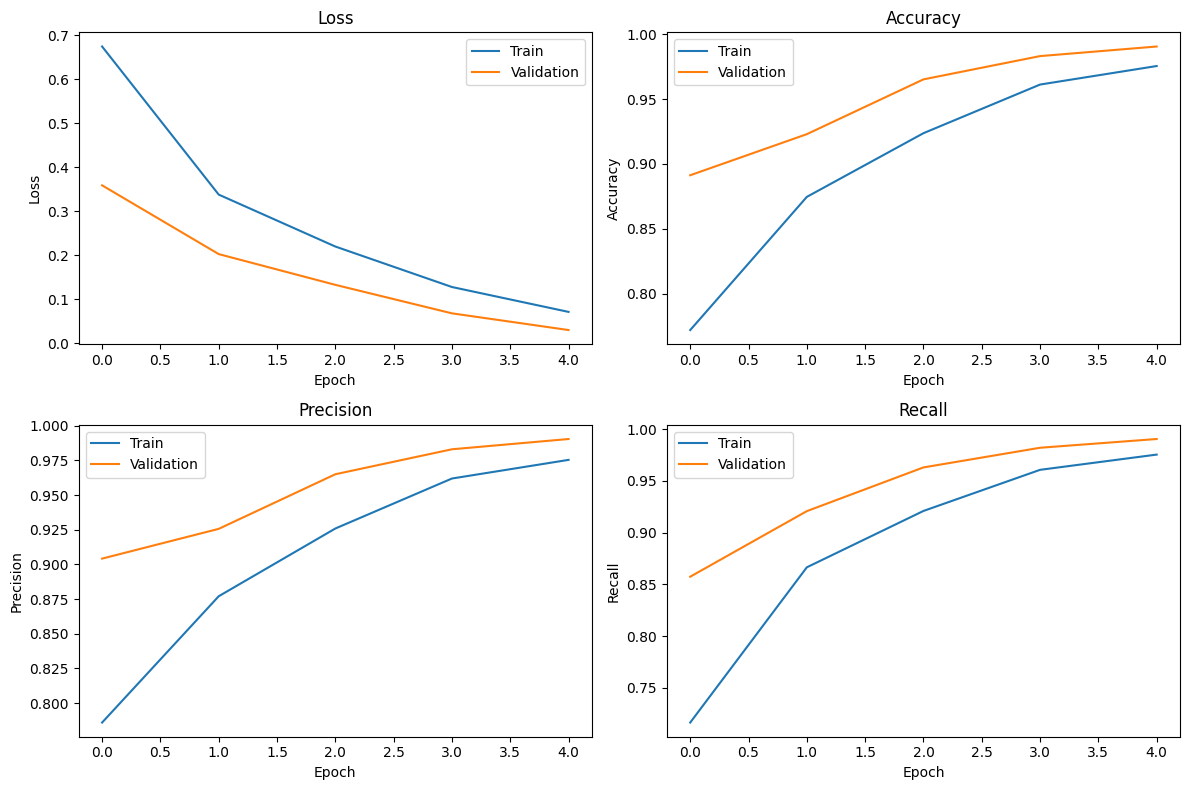

In [21]:
import matplotlib.pyplot as plt

# Select best model
best_model = models[8]
best_model_history = histories[8]

# Print model summary
best_model.summary()

# Plot accuracy, loss, precision, and recall
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(best_model_history.history['loss'])
axes[0, 0].plot(best_model_history.history['val_loss'])
axes[0, 0].set_title('Loss')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend(['Train', 'Validation'], loc='upper right')

axes[0, 1].plot(best_model_history.history['categorical_accuracy'])
axes[0, 1].plot(best_model_history.history['val_categorical_accuracy'])
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend(['Train', 'Validation'], loc='upper left')

axes[1, 0].plot(best_model_history.history['precision_8'])
axes[1, 0].plot(best_model_history.history['val_precision_8'])
axes[1, 0].set_title('Precision')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend(['Train', 'Validation'], loc='upper left')

axes[1, 1].plot(best_model_history.history['recall_8'])
axes[1, 1].plot(best_model_history.history['val_recall_8'])
axes[1, 1].set_title('Recall')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


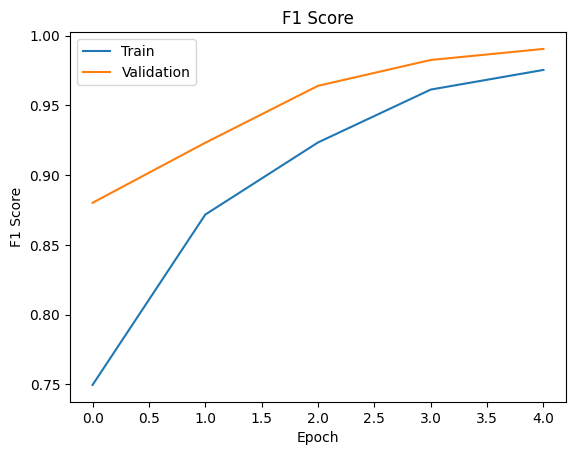

In [22]:
# Calculate F1 score
f1_train = [2 * (p * r) / (p + r) for p, r in zip(best_model_history.history['precision_8'], best_model_history.history['recall_8'])]
f1_val = [2 * (p * r) / (p + r) for p, r in zip(best_model_history.history['val_precision_8'], best_model_history.history['val_recall_8'])]

# Plot F1 score
plt.plot(f1_train)
plt.plot(f1_val)
plt.title('F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Test One Batch and Make Prediction

In [23]:
# get one batch and make a prediction
X_test, y_test = test.as_numpy_iterator().next()
yhat = best_model.predict(X_test)

# Convert logits to classes
y_pred = np.argmax(yhat, axis=1)
y_pred

# Convert true labels to class indices
y_test_indices = np.argmax(y_test, axis=1)

1/1 [==============================] - 0s 69ms/step


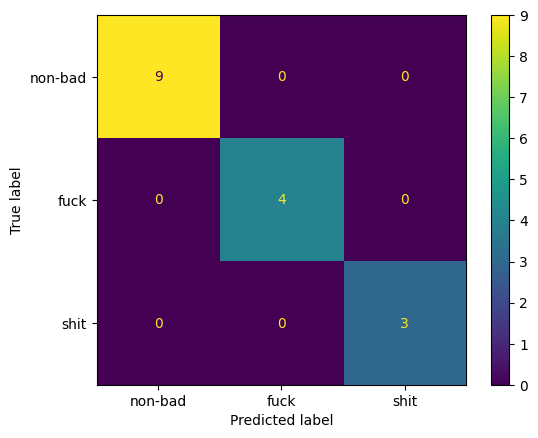

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_indices, y_pred)

# Use the class names as display labels
class_names = ['non-bad', 'fuck', 'shit']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

# Predict Entire Test Set and Display Confusion Matrix

In [25]:
# Predict the entire dataset
y_pred_all = []
y_test_indices_all = []

for X_test, y_test in test.as_numpy_iterator():
    yhat = best_model.predict(X_test)
    
    # Convert logits to classes
    y_pred = np.argmax(yhat, axis=1)
    y_pred_all.extend(y_pred)

    # Convert true labels to class indices
    y_test_indices = np.argmax(y_test, axis=1)
    y_test_indices_all.extend(y_test_indices)

1/1 [==============================] - 0s 13ms/step


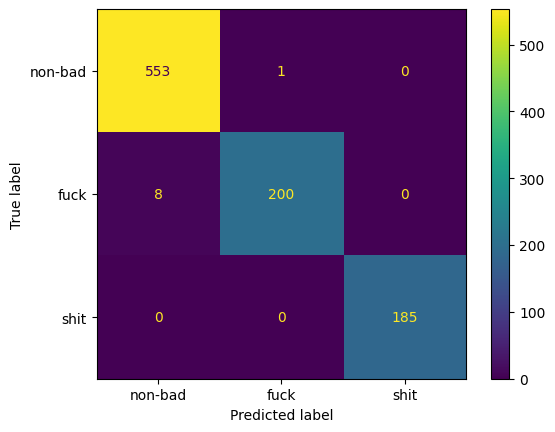

In [26]:
cm = confusion_matrix(y_test_indices_all, y_pred_all)

# Use the class names as display labels
class_names = ['non-bad', 'fuck', 'shit']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

# Save the model

In [27]:
 best_model.save("CNN_2c_32n_1d.h5")